# Luminosity Function, Mass Function, and Occupation Fraction

In this notebook is all the code that goes into generating the luminosity functions, mass functions, occupation fractions, etc. 

In [1]:
# first we import all relevant packages
from bulk import * # bulk.py stores a lot of my personal functions, i.e. for reading from the .data files and such
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pynbody
from scipy import stats
from scipy.stats import binned_statistic
import pandas as pd

pynbody.config['halo-class-priority'] =  [pynbody.halo.ahf.AHFCatalogue,
                                          pynbody.halo.GrpCatalogue,
                                          pynbody.halo.AmigaGrpCatalogue,
                                          pynbody.halo.legacy.RockstarIntermediateCatalogue,
                                          pynbody.halo.rockstar.RockstarCatalogue,
                                          pynbody.halo.subfind.SubfindCatalogue, pynbody.halo.hop.HOPCatalogue]

In [2]:
# we set the global matplotlib parameters so the fonts are all consistent and serif 
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

# Occupation Fraction

## Halo masses

First we need to get the halo mass of *every halo* in the baryonic runs, even the ones with no baryons. This way we can get the mass function. We store these values as arrays, along with boolean values of whether it is a satellite of halo 1, and the number of particles. 

In [14]:
# Hollis, note to self: this notebook must be run on a MathLAN computer since it requires access to raw simulation data

# h148 = '/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots/h148.cosmo50PLK.3072g3HbwK1BH.004096'
# h229 = '/home/christenc/Data/Sims/h229.cosmo50PLK.3072g/h229.cosmo50PLK.3072gst5HbwK1BH/snapshots/h229.cosmo50PLK.3072gst5HbwK1BH.004096'
# h242 = '/home/christenc/Data/Sims/h242.cosmo50PLK.3072g/h242.cosmo50PLK.3072gst5HbwK1BH/snapshots/h242.cosmo50PLK.3072gst5HbwK1BH.004096'
# h329 = '/home/christenc/Data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots/h329.cosmo50PLK.3072gst5HbwK1BH.004096'
h148 = '/home/akinshol/Data/Sims/newh148/h148.cosmo50PLK.3072g3HbwK1BH.004096'
h229 = '/home/akinshol/Data/Sims/newh229/h229.cosmo50PLK.3072gst5HbwK1BH.004096'
h242 = '/home/akinshol/Data/Sims/newh242/h242.cosmo50PLK.3072gst5HbwK1BH.004096'
h329 = '/home/akinshol/Data/Sims/newh329/h329.cosmo50PLK.3072gst5HbwK1BH.004096'

halo_mass = np.array([]) # array of halo masses
n_star = np.array([],dtype=int) # array of number of star particles
n_particles = np.array([])
simname = np.array([]) # array with simulation name
satellite = np.array([]) # boolean array describing whether each halo is a satellite
hostHalo1 = np.array([]) # boolean array describing whether a halo's host is halo 1

for simpath, name in zip([h148, h229, h242, h329], ['h148', 'h229','h242','h329']):
    # for simpath, name in zip([h329], ['h329']):
    print('Simulation %s' % simpath)
    # load the simulation
    s = pynbody.load(simpath)
    s.physical_units()
    h = s.halos(dummy=True)
    h1id = h[1].properties['#ID']
    
    for halo in h:
        hm = float(halo.properties['mass'])
        ns = int(halo.properties['n_star'])
        halo_mass = np.append(halo_mass, hm)
        n_star = np.append(n_star, ns)
        n_particles = np.append(n_particles, halo.properties['npart'])
        simname = np.append(simname,name)
        hostHalo = halo.properties['hostHalo']

        if hostHalo==-1:
            satellite = np.append(satellite, False)
            hostHalo1 = np.append(hostHalo1, False)
        else:
            satellite = np.append(satellite, True)
            if hostHalo==0:
                hostHalo1 = np.append(hostHalo1, True)
            else:
                hostHalo1 = np.append(hostHalo1, False)

    print('Mean halo mass %s' % np.mean(halo_mass))

Simulation /home/akinshol/Data/Sims/newh148/h148.cosmo50PLK.3072g3HbwK1BH.004096
Mean halo mass 64762637127.91023
Simulation /home/akinshol/Data/Sims/newh229/h229.cosmo50PLK.3072gst5HbwK1BH.004096
Mean halo mass 74439337209.19614
Simulation /home/akinshol/Data/Sims/newh242/h242.cosmo50PLK.3072gst5HbwK1BH.004096
Mean halo mass 72601779461.39116
Simulation /home/akinshol/Data/Sims/newh329/h329.cosmo50PLK.3072gst5HbwK1BH.004096
Mean halo mass 80929186370.57817


## DM-only halo masses

Now we need to do the same thing, except using the dark-matter-only simulations, for comparison. 

In [4]:
h148 = '/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072/h148.cosmo50PLK.3072.004096'
h229 = '/home/christenc/Data/Sims/h229.cosmo50PLK.3072g/h229.cosmo50PLK.3072/h229.cosmo50PLK.3072.004096'
h242 = '/home/christenc/Data/Sims/h242.cosmo50PLK.3072g/h242.cosmo50PLK.3072/h242.cosmo50PLK.3072.004096'
h329 = '/home/christenc/Data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072/h329.cosmo50PLK.3072.004096'
# h329 hostHalo=0 means halo 1 sat, h242 hostHalo=0 means halo1 sat, 0, h229 hostHalo=0 means halo 1 sat, h148 hostHalo=0

dm_halo_mass = np.array([], dtype=float)
dm_simname = np.array([], dtype=str)
dm_nparticles = np.array([],dtype=int)
dm_hostHalo1 = np.array([], dtype=bool)

for simpath, name in zip([h148, h229, h242, h329], ['h148','h229','h242','h329']):
    s = pynbody.load(simpath)
    s.physical_units()
    h = s.halos(dummy=True)
    print(f'Loading DM-only simulation {name}')

    for halo in h:
        dm_halo_mass = np.append(dm_halo_mass, halo.properties['mass'])
        dm_simname = np.append(dm_simname, name)
        dm_nparticles = np.append(dm_nparticles, halo.properties['npart'])

        if halo.properties['hostHalo'] == 0:
            dm_hostHalo1 = np.append(dm_hostHalo1, True)
        else:
            dm_hostHalo1 = np.append(dm_hostHalo1, False)

    print(f'Mean halo mass {np.mean(dm_halo_mass[dm_simname==name]):.2f} Msol')

Loading DM-only simulation h148
Mean halo mass 117063946801.69 Msol
Loading DM-only simulation h229
Mean halo mass 141877379597.85 Msol
Loading DM-only simulation h242
Mean halo mass 94342535508.76 Msol
Loading DM-only simulation h329
Mean halo mass 164004639310.03 Msol


In [20]:
# halo_mass = np.array([]) # array of halo masses
# n_star = np.array([],dtype=int) # array of number of star particles
# n_particles = np.array([])
# simname = np.array([]) # array with simulation name
# satellite = np.array([]) # boolean array describing whether each halo is a satellite
# hostHalo1 = np.array([]) # boolean array describing whether a halo's host is halo 1

d = pd.DataFrame({'M_vir': halo_mass, 'n_star': n_star, 'n_particles': n_particles, 'sim': simname, 'satellite': np.array(satellite, dtype=bool), 'is_host_1': np.array(hostHalo1, dtype=bool)})
d.to_csv('output/Occupation_Fraction_Data.csv', index=False)


## Making the plot

Now we plot the satellite luminosity function, satellite mass function, and satellite occupation fractions all at once. This is so that we can direclty compare the plots to see why there are differences between the individual simulations. 

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


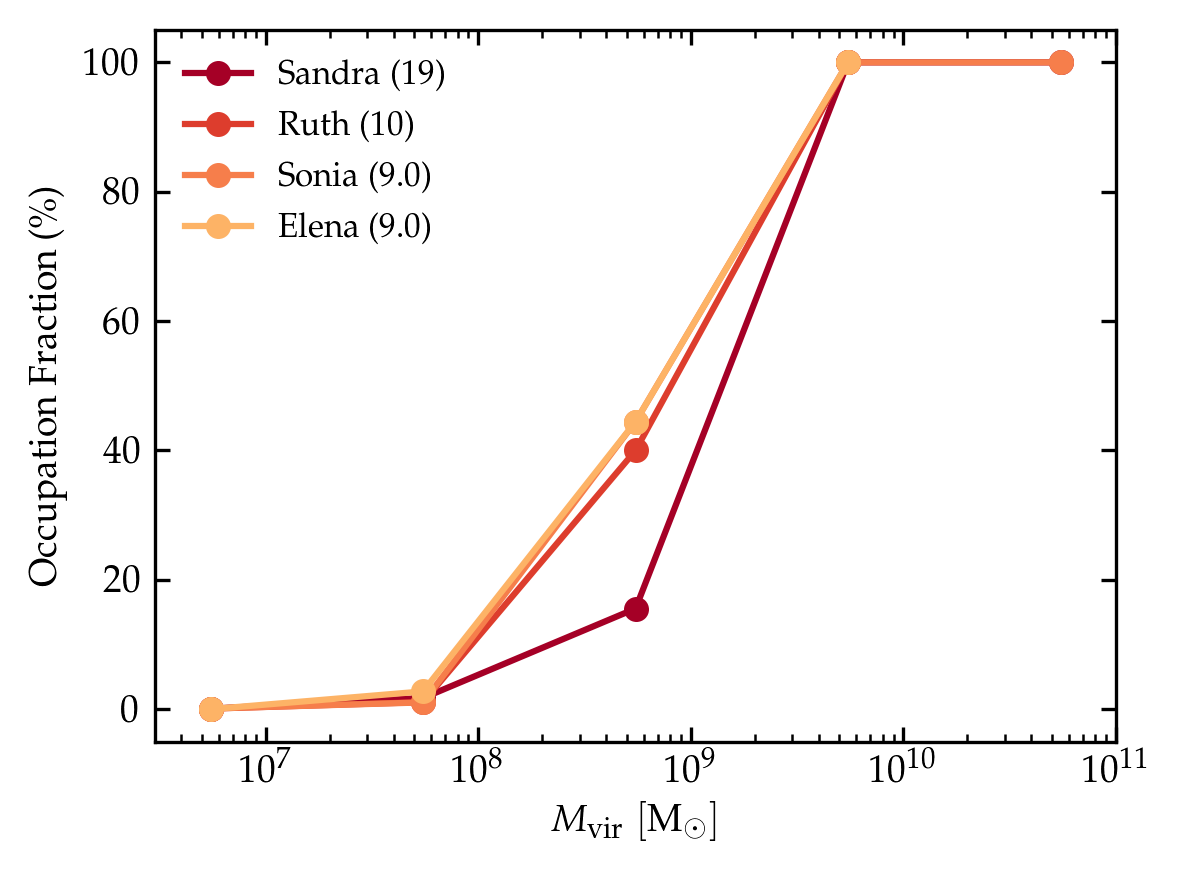

In [35]:
## occupation fraction
# put it into 1 dex bins
binEdges = 10**np.arange(4,14,1)

dataframe = pd.DataFrame(columns=['bincenter', 'h148','h229','h242','h329'])

fig, ax = plt.subplots(1,1,dpi=300,figsize=(4,3))

names = ['h148','h229','h242','h329']
labels = ['Sandra (19)','Ruth (10)','Sonia (9.0)','Elena (9.0)']
colors = ['#A50026','#DD3D2D', '#F67E4B', '#FDB366']

for name,label,color in zip(names,labels,colors):
    # boolean array detailing which data to use from the arrays we made in the last cell
    f = np.array(simname==name) & np.array(hostHalo1,dtype=bool) 
    
    mass = halo_mass[f]
    nstar = n_star[f]
    
    # remove one outlier in h148
    if name=='h148':
        mass = np.delete(mass,np.argmin(mass))
        nstar = np.delete(nstar,np.argmin(mass))
        
    y1, binEdges = np.histogram(mass, bins=binEdges) # N halos
    bc = 0.5*(binEdges[1:] + binEdges[:-1])
    y2, binEdges = np.histogram(mass[nstar>1], bins=binEdges) # N halos with > 10 star particles
    dataframe[name] = y2/y1
    dataframe['bincenter'] = bc
    ax.plot(bc,100*y2/y1,label=label, color=color, marker='o', markersize=5)


ax.semilogx()
ax.set_ylabel(r'Occupation Fraction ($\%$)')
ax.set_xlabel(r'$M_{\mathrm{vir}}\ [\mathrm{M}_{\odot}]$')
ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.legend(prop={'size':8},frameon=False)
ax.set_xlim(3e6,1e11)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.show()

dataframe.to_csv('output/Occupation_Fraction_1dex.csv', index=False)



# Combined Luminosity Function, Mass Function, and Occupation Fraction

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:178: RuntimeWarning: invalid value encountered in true_divide


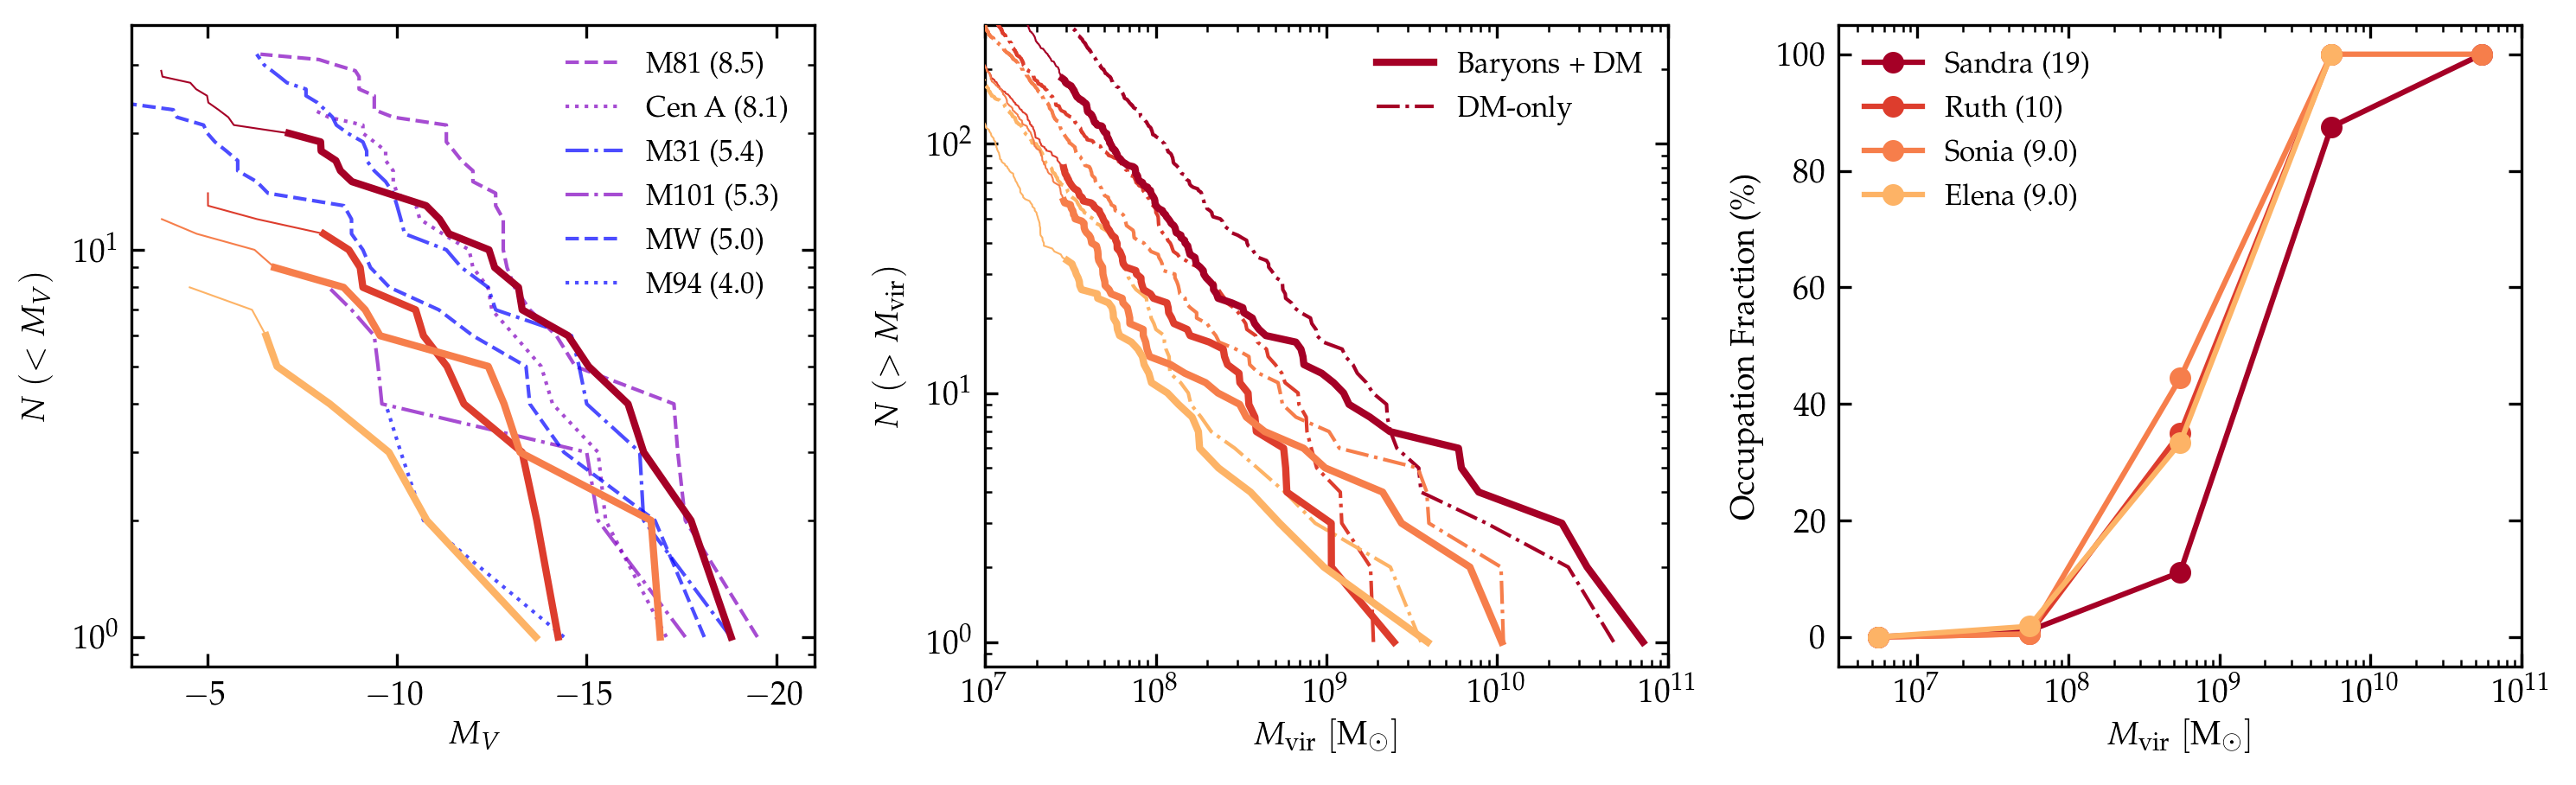

In [127]:
# Observational Data

MW = [-14.4,-13.5,-1.5,-4.2,-2.7,-2.5,-2.7,-4.1,-5.8,-18.1,-16.8,-6.3,-8.8,-8.8,-11.1,-9.3,-5.5,-9.1,-6.6,-13.4,
      -5.8,-4.9,-5.2,-5.0,-8.6,-9.8,-12] # McConnachie (2012) # MW magnitude is unknown 
CenA = [-9.4,-8.2,-12.5,-12.4,-9.9,-7.8,-9.1,-9.9,-15.5,-9.7,-13.8,-13.1,-9.1,-9.7,-15.3,-11.2,-14.1,
       -10.5,-17.1,-10.6,-12.0,-10.0,-11.9] # Crnojevic et al. (2019) # Cen A Magnitude -21 (removed)
M31 = [-16.4,-8.1,-16.5,-8.7,-11.7,-7.9,-10,-9.7,-7.1,-6.9,-9.1,-7.6,-10.2,-6.3,-6.4,-14.6,-9.9,-8.4,-9.4,-6.7,
       -12.4,-14.8,-8.3,-9.2,-18.8,-7.6,-12.6,-6.5,-15,-10.1,-11.3,-9.2] # McConnachie (2012) # M31 magnitude is ~ -22
M101 = [-9.5,-8.2,-8.8,-9.4,-9.6,-15.0,-15.3,-17.6] # Bennet et al (2019) # M101 magnitude -20.8 (removed)
M94 = np.array([-10.1,-9.7]) # first two entries from Smercina et al. (2018)
M94 = np.append(M94,[-14.4,-10.7]) # eyeballed values from Fig 7 in Bennett et al (2019) (cannot find paper on these two)
M81_r = np.array([-13.3,-11.7,-18.0,-19.9 ,-11.7,-13.2,-13.2,-6.8,-9.4,-13.9,-13.0,-9.8,-9.4,-13.0,-13.2,-17.8,-12.4 ,-8.8,-9.8,-9.3,-12.1,-17.7,-15.1,-12.4,-13.5,-9.8,-14.6,-10.3,-11.7,-11.9,-9.4])
# the above is direclty from Table 3 of Chiboucas et al
M81 = M81_r + 0.4 # emperical relation from Crnojevic et al (2019)
M81 = np.append(M81, -7.94) # from Smercina et al (2018)

# Setup
nbins = 10
names = ['h148','h229','h242','h329']
labels = ['Sandra (19)','Ruth (10)','Sonia (9.0)','Elena (9.0)']
colors = ['#A50026','#DD3D2D', '#F67E4B', '#FDB366']

obs_mags = [M81, CenA, M31, M101, MW, M94]
obs_names = [r'M81 ($8.5$)', r'Cen A ($8.1$)', r'M31 ($5.4$)', r'M101 ($5.3$)', r'MW ($5.0$)', r'M94 ($4.0$)']
obs_colors = ['#8000bf', '#8000bf', 'b', '#8000bf', 'b', 'b'] 
obs_styles = ['--',':','-.','-.','--',':']

obs = True
sim = True

fig,ax = plt.subplots(1,3,figsize=(10,3.1),dpi=300)


obs_plots, obs_labels = [], []

if obs:
    for mags,name,color,style in zip(obs_mags, obs_names, obs_colors,obs_styles):  
        y = np.array(range(len(mags)))+1
        x = np.sort(np.array(mags,dtype=float))
        
        ax[0].plot(x,y,linestyle=style,mew=0,ms=3,linewidth=1.,color=color,label=name,alpha=0.7,zorder=1)
                
output = pd.DataFrame() # initialize dataframe object which will store the LumFunc data as csv

if sim:
    for name,color in zip(names,colors):
        # read the data, and get magnitudes for those halos whose host is halo 1 (i.e. whichHost(data)==1)
        data = read_file(name)
        data = data[whichHost(data)==1]
        mags = data['V_mag']
        
        # create temporary dataframe and then add to the output, storing relevant data
        temp = pd.DataFrame()
        temp['V_mag'] = np.array(mags, dtype=float)
        temp['N_star'] = np.array(data.n_star, dtype=int)
        temp['log10Mstar'] = np.log10(np.array(data.M_star, dtype=float))
        temp['sim'] = np.array([name]*len(mags))
        output = output.append(temp)
        
        # the y axis is range of mags (+1) since we sort the mags and want each magnitude to bring change the lumfunc by 1
        # the x axis is the sorted magnitudes 
        y = np.array(range(len(mags)))+1
        x = np.sort(np.array(mags,dtype=float)) 
        
        # plot the data as a thin line (since this includes the cutoff)
        ax[0].plot(x,y,'-',linewidth=0.5,linestyle='-',color=color,zorder=5)
        
        # now plot the regular size line above the cutoff
        data = read_file(name)
        data = data[(data.n_star > 10) & (whichHost(data)==1)]
        mags = data['V_mag']
        
        y = np.array(range(len(mags)))+1
        x = np.sort(np.array(mags,dtype=float))
        
        # now we plot as a thick line
        ax[0].plot(x,y,'-',linestyle='-',mew=0,ms=5,linewidth=2,color=color,label=None,zorder=10)
        
# save the output dataframe as a csv
output.to_csv('output/LuminosityFunction.csv',sep=',', header=True, index=False)
        

ax[0].set_ylabel(r'$N\ (<M_V)$')
ax[0].set_xlabel(r'$M_V$')
ax[0].invert_xaxis()
ax[0].set_xlim(-3,-21)
ax[0].semilogy()
ax[0].tick_params(direction='in',which='both')
ax[0].yaxis.set_ticks_position('both')
ax[0].xaxis.set_ticks_position('both')
ax[0].legend(loc='upper right', ncol=1, frameon=False, prop={'size':8})


output = pd.DataFrame() # initial new data frame for the mass function

for name, label ,color in zip(names, labels ,colors):
    f = (simname==name) & (np.array(hostHalo1,dtype=bool))
    mass = np.log10(halo_mass[f])
    
    # add data to output dataframe
    temp = pd.DataFrame()
    temp['log10Mvir'] = mass
    temp['n_particles'] = n_particles[f]
    temp['sim'] = np.array([name]*len(mass))
    output = output.append(temp)
    
    # same as before but now we flip since higher values should have less 
    x = np.flip(np.sort(mass))
    y = np.array(range(len(mass)))+1
    
    # plot as a thin line
    ax[1].plot(10**x,y,'-',linewidth=0.5,linestyle='-',color=color,zorder=5)
    
    # now, we set a cutoff
    f = (simname==name) & (np.array(hostHalo1,dtype=bool)) & (n_particles > 1000)
    mass = np.log10(halo_mass[f])
    
    
    x = np.flip(np.sort(mass))
    y = np.array(range(len(mass)))+1
    
    # add only one label
    if name=='h148':
        l1 = 'Baryons + DM'
        l2 = 'DM-only'
    else:
        l1,l2 = None, None
    
    # plot as a thicker line
    ax[1].plot(10**x,y,'-',linewidth=2,color=color,zorder=6,label=l1)
    
    # now do the same for the DM-only simulation
    f = (dm_simname==name) & (dm_hostHalo1)
    mass = np.log10(dm_halo_mass[f])

    x = np.flip(np.sort(mass))
    y = np.array(range(len(mass)))+1
    
    ax[1].plot(10**x, y, '-.', linewidth=1, color=color, zorder=4, label=l2)

# save the data to a csv
output.to_csv('output/MassFunction.csv',sep=',', header=True, index=False)

    
ax[1].set_ylabel(r'$N\ (>M_\mathrm{vir})$')
ax[1].set_xlabel(r'$M_{\mathrm{vir}}\ [\mathrm{M}_{\odot}]$')
ax[1].loglog()
ax[1].tick_params(direction='in',which='both')
ax[1].yaxis.set_ticks_position('both')
ax[1].xaxis.set_ticks_position('both')
ax[1].set_xlim(1e7,1e11)
ax[1].set_ylim(0.8,3e2)
ax[1].legend(prop={'size':8},frameon=False)



## occupation fraction
# put it into 1 dex bins
binEdges = 10**np.arange(4,14,1)


for name,label,color in zip(names,labels,colors):
    # boolean array detailing which data to use from the arrays we made in the last cell
    f = np.array(simname==name) & np.array(hostHalo1,dtype=bool) 
    
    mass = halo_mass[f]
    nstar = n_star[f]
    
    # remove one outlier in h148
    if name=='h148':
        mass = np.delete(mass,np.argmin(mass))
        nstar = np.delete(nstar,np.argmin(mass))
        
    y1, binEdges = np.histogram(mass, bins=binEdges) # N halos
    bc = 0.5*(binEdges[1:] + binEdges[:-1])
    y2, binEdges = np.histogram(mass[nstar>10], bins=binEdges) # N halos with > 10 star particles
    
    ax[2].plot(bc,100*y2/y1,label=label, color=color, marker='o', markersize=5)


ax[2].semilogx()
ax[2].set_ylabel(r'Occupation Fraction ($\%$)')
ax[2].set_xlabel(r'$M_{\mathrm{vir}}\ [\mathrm{M}_{\odot}]$')
ax[2].tick_params(direction='in',which='both')
ax[2].yaxis.set_ticks_position('both')
ax[2].xaxis.set_ticks_position('both')
ax[2].legend(prop={'size':8},frameon=False)
ax[2].set_xlim(3e6,1e11)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.savefig('output/lum_mass_occupation.png',dpi=300)
plt.show()